In [1]:
# -*- coding: utf-8 -*-
import openmc
import os
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys
from PIL import Image
import numpy as np

In [2]:
CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))
from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL
from src.utils.pre_processing.pre_processing import remove_previous_results, parallelepiped, plot_geometry, mesh_tally_plane
from src.utils.post_preocessing.post_processing import load_mesh_tally, gaussian_energy_broadening, Pulse_height_tally
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

In [3]:
# Définition des matériaux
materials = openmc.Materials([CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL])

In [4]:
# Surfaces
sphere = openmc.Sphere(r=1.0, surface_id=1)
detector = openmc.Sphere(x0=10., r=1.0, surface_id=2)
outer_boundary = openmc.Sphere(r=200.0, surface_id=3, boundary_type='vacuum')


In [5]:

detector_cell = openmc.Cell(name="detector_cell")
detector_cell.fill = CDTE_MATERIAL
detector_cell.region = -detector

# Air cell (everything else inside the outer boundary, minus source and detector)
outer_boundary_cell = -outer_boundary
void_region = outer_boundary_cell & ~detector_cell.region
void_cell = openmc.Cell(name="air_cell", fill=AIR_MATERIAL, region=void_region)

universe = openmc.Universe(cells=[detector_cell, void_cell])
geometry = openmc.Geometry(universe)

In [6]:
geometry.export_to_xml()
materials.export_to_xml()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

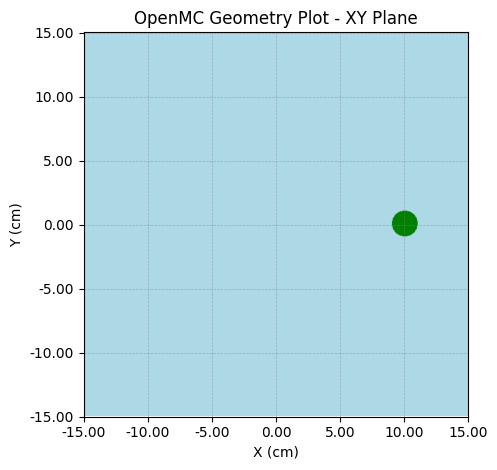

In [7]:
plot_geometry(materials=materials, width=30, height=30, saving_figure=False)

In [8]:
# Création de la source
source = openmc.IndependentSource()
source.space = openmc.stats.spherical_uniform(r_outer=1.25)
source.energy = openmc.stats.Discrete([661_700], [1.0])  # Énergie du photon de 662 keV pour Cs137
source.angle = openmc.stats.Monodirectional([1.0, 0.0, 0.0])
source.particle = "photon"

In [9]:
tallies = openmc.Tallies([])
mesh_tally = mesh_tally_plane(plane="xy", particule_type="photon", lower_left=(-15,-15), upper_right=(15,15))
tallies.append(mesh_tally)

# Tally pour le spectre d'énergie déposée dans le détecteur
energy_bins = np.linspace(1e-3, 1.0e6, 1001)
energy_filter = openmc.EnergyFilter(energy_bins)
cell_filter = openmc.CellFilter(detector_cell)

energy_dep_tally = openmc.Tally(name="pulse-height")
energy_dep_tally.filters = [cell_filter, energy_filter]
energy_dep_tally.scores = ["pulse-height"]
tallies.append(energy_dep_tally)

In [10]:
# Configuration de la simulation
settings = openmc.Settings()
batches_number = 100
settings.batches = batches_number
settings.particles = 10**4
settings.source = source
settings.photon_transport = True
settings.run_mode = "fixed source"
settings.verbose = True

In [11]:
# Export des fichiers nécessaires pour la simulation
settings.export_to_xml()
tallies.export_to_xml()

In [12]:
# Exécution de la simulation
remove_previous_results(batches_number)
os.environ["OMP_NUM_THREADS"] = "1"
openmc.run()
print("Calcul fini")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [13]:
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")

/Users/simonfoucambert/Documents/projects/open-mc-project/src/utils/post_preocessing/post_processing.py:44: RuntimeWarning: invalid value encountered in divide
  flux_error = flux_error / flux_data


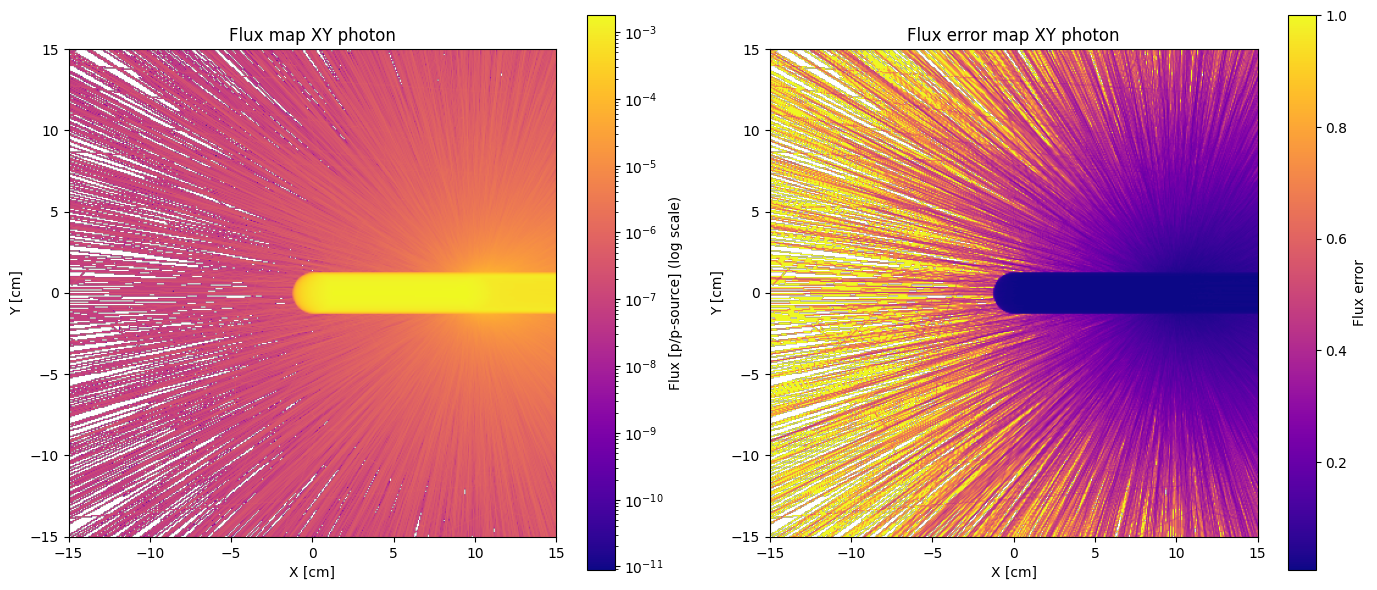

In [14]:
load_mesh_tally(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh", particule_type="photon",
                plane = "xy", upper_right=(15, 15), lower_left=(-15, -15),
                zoom_x=(-15, 15), zoom_y=(-15, 15), saving_figure=False, plot_error=True)

/var/folders/26/3y3qv5rj2xb5dcx9lwklyrp80000gn/T/ipykernel_36574/940784144.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


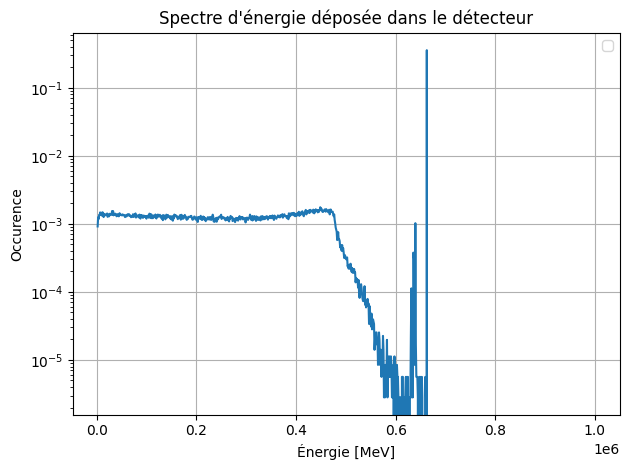

In [ ]:
pht = Pulse_height_tally(name="pulse-height")
spectrum, spectrum_std = pht.get_spectrum(statepoint_file=sp, normalize=True)
energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])

plt.figure()
plt.semilogy(energy_bin_centers, spectrum)
plt.xlabel("Énergie [MeV]")
plt.ylabel("Occurence")
plt.title("Spectre d'énergie déposée dans le détecteur")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/26/3y3qv5rj2xb5dcx9lwklyrp80000gn/T/ipykernel_36574/2781057239.py:4: RuntimeWarning: invalid value encountered in divide
  plt.semilogy(energy_bin_centers, spectrum_std/spectrum)
/var/folders/26/3y3qv5rj2xb5dcx9lwklyrp80000gn/T/ipykernel_36574/2781057239.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


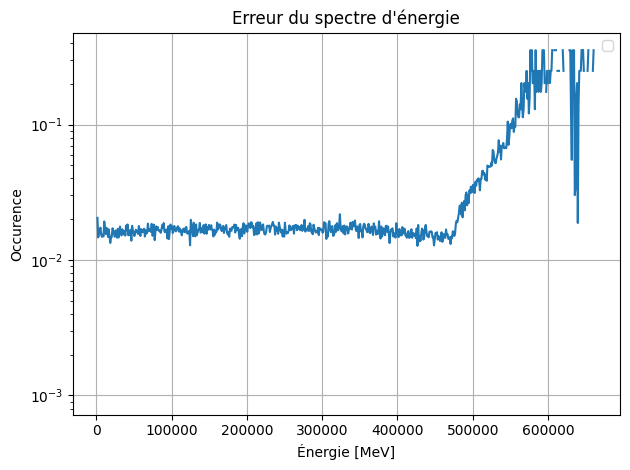

In [22]:

# Récupération des énergies moyennes par bin (approximation)
# Tracé
plt.figure()
plt.semilogy(energy_bin_centers, spectrum_std/spectrum)
plt.xlabel("Énergie [MeV]")
plt.ylabel("Occurence")
plt.title("Erreur du spectre d'énergie")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

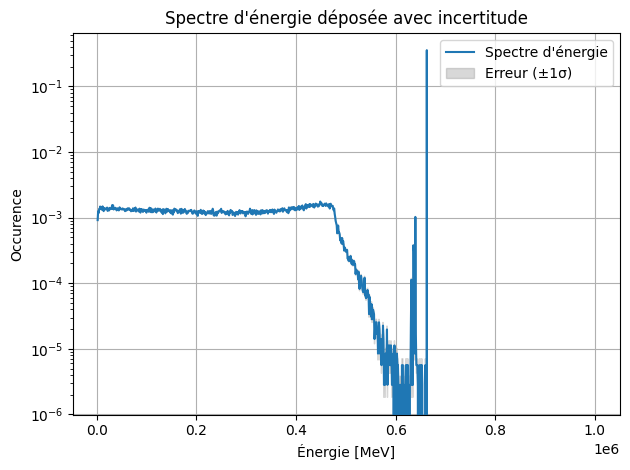

In [23]:
plt.figure()
plt.semilogy(energy_bin_centers, spectrum, label="Spectre d'énergie")
plt.fill_between(
    energy_bin_centers,
    spectrum - spectrum_std,
    spectrum + spectrum_std,
    color='gray',
    alpha=0.3,
    label="Erreur (±1σ)"
)
plt.xlabel("Énergie [MeV]")
plt.ylabel("Occurence")
plt.title("Spectre d'énergie déposée avec incertitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
a, b, c = 1, 1, 0.0002
number_broadening_samples = 1e6
samples = np.random.choice(energy_bin_centers[1:], size=int(number_broadening_samples), p=spectrum[1:]/np.sum(spectrum[1:]))
broaded_spectrum = gaussian_energy_broadening(E=samples, a=a, b=b, c=c)

broaded_spectrum, _ = np.histogram(broaded_spectrum, bins=energy_bins)
renormalized_broaded_spectrum = broaded_spectrum / np.sum(broaded_spectrum) * np.sum(pulse_height_values[1:])

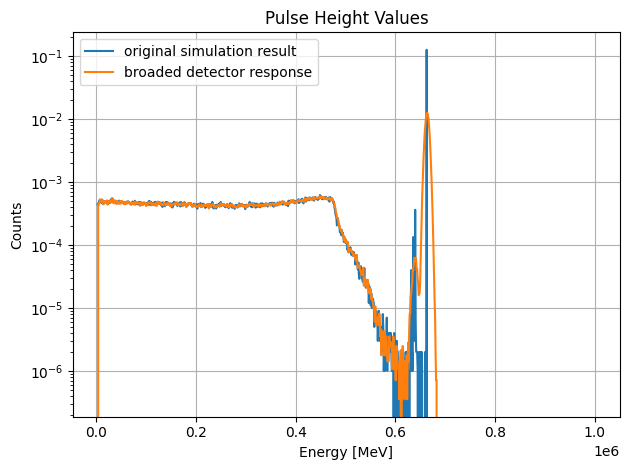

In [25]:
plt.figure()
plt.semilogy(energy_bin_centers[1:], pulse_height_values[1:], label="original simulation result")
plt.semilogy(energy_bin_centers[1:], renormalized_broaded_spectrum[1:], label="broaded detector response")
plt.legend()
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts')
plt.title('Pulse Height Values')
plt.grid(True)
plt.tight_layout()